In [2]:
import os
from typing import Optional, Tuple, List, Union, Callable

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from tqdm import trange

# For repeatability
# seed = 3407
# torch.manual_seed(seed)
# np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def polar_to_cartesian(r, theta, phi, deg=True):
    if deg:
        phi = phi * np.pi / 180
        theta = theta * np.pi / 180
    cx = np.sin(phi) * np.cos(theta)
    cy = np.sin(phi) * np.sin(theta)
    cz = np.cos(phi)
    return r * np.stack([cx, cy, cz])

def look_at(eye, at=np.array([0, 0, 0]), up=np.array([0, 0, 1]), eps=1e-5):
    at = at.astype(float).reshape(1, 3)
    up = up.astype(float).reshape(1, 3)

    eye = eye.reshape(-1, 3)
    up = up.repeat(eye.shape[0] // up.shape[0], axis=0)
    eps = np.array([eps]).reshape(1, 1).repeat(up.shape[0], axis=0)

    z_axis = eye - at
    z_axis /= np.max(np.stack([np.linalg.norm(z_axis, axis=1, keepdims=True), eps]))

    x_axis = np.cross(up, z_axis)
    x_axis /= np.max(np.stack([np.linalg.norm(x_axis, axis=1, keepdims=True), eps]))

    y_axis = np.cross(z_axis, x_axis)
    y_axis /= np.max(np.stack([np.linalg.norm(y_axis, axis=1, keepdims=True), eps]))

    r_mat = np.concatenate((x_axis.reshape(-1, 3, 1), y_axis.reshape(-1, 3, 1), z_axis.reshape(-1, 3, 1)), axis=2)

    return r_mat

def get_render_poses(radius, num_volumes, angle_range=(0, 360), theta=0, N=40, swap_angles=False):
    poses = []
    theta = max(0.1, theta)
    for i in range(num_volumes):
        for angle in np.linspace(angle_range[0],angle_range[1],N+1)[:-1]:
            angle = max(0.1, angle)
            # print(angle)
            if swap_angles:
                loc = polar_to_cartesian(radius, theta, angle, deg=True)
            else:
                loc = polar_to_cartesian(radius, angle, theta, deg=True)
            R = look_at(loc)[0]
            RT = np.concatenate([R, loc.reshape(3, 1)], axis=1)
            # print(RT)
            # print(angle)
            newrow = [0, 0, 0, 1]
            RT = np.vstack([RT, newrow])
            poses.append(RT)
            # print(RT)
    return torch.from_numpy(np.stack(poses))

In [4]:
render_radius = 9.5
num_volumes = 1
N = 72
render_poses = get_render_poses(render_radius, num_volumes, N=N)

In [5]:
print(render_poses)

tensor([[[-1.7453e-03, -1.0000e+00,  1.7453e-03,  1.6581e-02],
         [ 1.0000e+00, -1.7453e-03,  3.0462e-06,  2.8939e-05],
         [ 0.0000e+00,  1.7453e-03,  1.0000e+00,  9.5000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[-8.7156e-02, -9.9619e-01,  1.7387e-03,  1.6518e-02],
         [ 9.9619e-01, -8.7156e-02,  1.5212e-04,  1.4451e-03],
         [ 0.0000e+00,  1.7453e-03,  1.0000e+00,  9.5000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[-1.7365e-01, -9.8481e-01,  1.7188e-03,  1.6329e-02],
         [ 9.8481e-01, -1.7365e-01,  3.0307e-04,  2.8792e-03],
         [ 0.0000e+00,  1.7453e-03,  1.0000e+00,  9.5000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        ...,

        [[ 2.5882e-01, -9.6592e-01,  1.6859e-03,  1.6016e-02],
         [ 9.6593e-01,  2.5882e-01, -4.5172e-04, -4.2914e-03],
         [-0.0000e+00,  1.7453e-03,  1.0000e+00,  9.5000e+00],
         [ 0.0000e+00,  0.0000e+00,

In [6]:
def get_rays_ortho(H, W, c2w, size_h, size_w):
    """Similar structure to 'get_rays' in submodules/nerf_pytorch/run_nerf_helpers.py"""
    # # Rotate ray directions from camera frame to the world frame
    rays_d = -c2w[:3, 2].view(1, 1, 3).expand(W, H, -1)  # direction to center in world coordinates

    i, j = torch.meshgrid(torch.linspace(0, W - 1, W),
                          torch.linspace(0, H - 1, H))  # pytorch's meshgrid has indexing='ij'
    i = i.t()
    j = j.t()

    # Translation from center for origins
    rays_o = torch.stack([(i - W * .5), -(j - H * .5), torch.zeros_like(i)], -1)

    # Normalize to [-size_h/2, -size_w/2]
    rays_o = rays_o * torch.tensor([size_w / W, size_h / H, 1]).view(1, 1, 3)

    # Rotate origins to the world frame
    rays_o = torch.sum(rays_o[..., None, :] * c2w[:3, :3], -1)  # dot product, equals to: [c2w.dot(dir) for dir in dirs]

    # Translate origins to the world frame
    rays_o = rays_o + c2w[:3, -1].view(1, 1, 3)

    return rays_o, rays_d

In [7]:
ray_o, ray_d = get_rays_ortho(128, 128, render_poses[0], 19, 19)

/home/agp3/anaconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
ray_o[64, 64, :]

tensor([1.6581e-02, 2.8939e-05, 9.5000e+00], dtype=torch.float64)

In [9]:
ray_d

tensor([[[-1.7453e-03, -3.0462e-06, -1.0000e+00],
         [-1.7453e-03, -3.0462e-06, -1.0000e+00],
         [-1.7453e-03, -3.0462e-06, -1.0000e+00],
         ...,
         [-1.7453e-03, -3.0462e-06, -1.0000e+00],
         [-1.7453e-03, -3.0462e-06, -1.0000e+00],
         [-1.7453e-03, -3.0462e-06, -1.0000e+00]],

        [[-1.7453e-03, -3.0462e-06, -1.0000e+00],
         [-1.7453e-03, -3.0462e-06, -1.0000e+00],
         [-1.7453e-03, -3.0462e-06, -1.0000e+00],
         ...,
         [-1.7453e-03, -3.0462e-06, -1.0000e+00],
         [-1.7453e-03, -3.0462e-06, -1.0000e+00],
         [-1.7453e-03, -3.0462e-06, -1.0000e+00]],

        [[-1.7453e-03, -3.0462e-06, -1.0000e+00],
         [-1.7453e-03, -3.0462e-06, -1.0000e+00],
         [-1.7453e-03, -3.0462e-06, -1.0000e+00],
         ...,
         [-1.7453e-03, -3.0462e-06, -1.0000e+00],
         [-1.7453e-03, -3.0462e-06, -1.0000e+00],
         [-1.7453e-03, -3.0462e-06, -1.0000e+00]],

        ...,

        [[-1.7453e-03, -3.0462e-06, -1

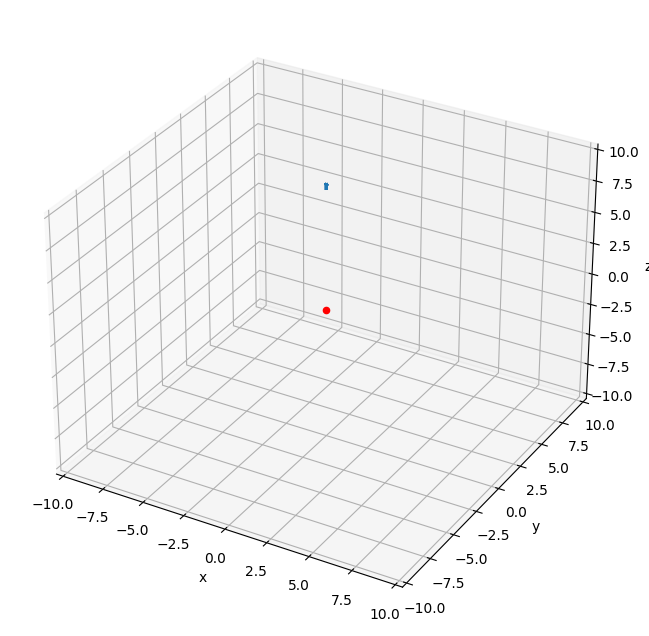

In [27]:
height = 128
width = 128

dirs = []
origins = []

for pose in render_poses[:72]:
    # print(pose)
    # get_rays(central pixel)
    ray_origin, ray_direction = get_rays_ortho(128, 128, pose, 19, 19)
    origins.append(ray_origin[height // 2, width // 2, :])
    # dirs.append(ray_direction[height // 2, width // 2, :])
    dirs.append(torch.asarray([0, 0, 1]))


dirs = torch.stack(dirs)
origins = torch.stack(origins)
dirs = dirs.cpu()
origins = origins.cpu()

ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.scatter(0, 0, 0, color="red")

_ = ax.quiver(
  origins[..., 0].flatten(),
  origins[..., 1].flatten(),
  origins[..., 2].flatten(),
  dirs[..., 0].flatten(),
  dirs[..., 1].flatten(),
  dirs[..., 2].flatten(), length=0.5, normalize=True)
plt.show()

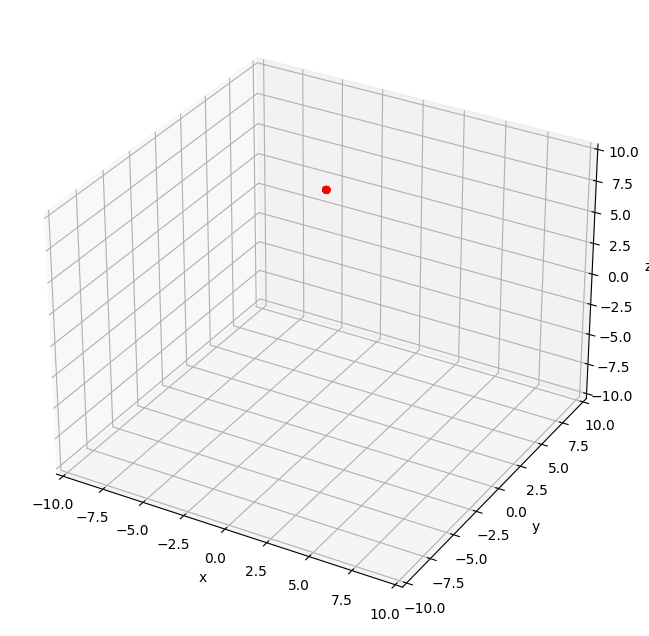

In [11]:
ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)

x = []
y = []
z = []
for pose in render_poses[:72]:
    ray_origin, ray_direction = get_rays_ortho(128, 128, pose, 19, 19)
    ray_origin = ray_origin[height // 2, width // 2, :]
    # origins.append(ray_origin[height // 2, width // 2, :])
    # dirs.append(ray_direction[height // 2, width // 2, :])
    # pt = pt.cpu().numpy()
    x.append(ray_origin[0])
    y.append(ray_origin[1])
    z.append(ray_origin[2])
    
ax.scatter(x, y, z, color="red")